In [11]:
import pandas as pd

df = pd.read_csv("df_cleaned.csv")
df.head()

,path,gender
0,common_voice_en_41534732.mp3,male_masculine
1,common_voice_en_41472897.mp3,male_masculine
2,common_voice_en_41909191.mp3,male_masculine
3,common_voice_en_41650031.mp3,male_masculine
4,common_voice_en_41888663.mp3,male_masculine


In [12]:
import librosa
import parselmouth
import numpy as np

FILE_PATH = "../../datasets/cv-corpus-20.0-delta-2024-12-06/en/clips/"
SAMPLE_RATE = 16000
TARGET_RMS = 0.1  # Target RMS energy level

In [13]:
def trim_silence(y):
    """
    Trims leading and trailing silence from an audio signal while preserving small pauses.
    """
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    return y_trimmed

In [14]:
def load_and_normalize_audio(file_name):
    """Loads and normalizes an audio file to a target RMS loudness."""
    # Load the audio as a waveform `y`
    y, sr = librosa.load(FILE_PATH + file_name, sr=SAMPLE_RATE)
    
    y = trim_silence(y)

    # Compute current RMS
    rms = np.sqrt(np.mean(y**2))

    # Compute scaling factor
    scaling_factor = TARGET_RMS / (rms + 1e-6)  # Avoid division by zero

    # Apply normalization
    y_normalized = y * scaling_factor

    return y_normalized, sr

In [15]:
def extract_fundamental(y, sr):
    """
    Extracts fundamental frequency (F0) using Parselmouth and computes percentiles.
    """
    # Convert audio to Parselmouth Sound object
    snd = parselmouth.Sound(y, sampling_frequency=sr)

    # Extract pitch using Praat's optimized method
    pitch = snd.to_pitch(time_step=0.025, pitch_floor=50, pitch_ceiling=500)

    # Extract F0 values from the selected frequency array
    f0_values = pitch.selected_array['frequency']  # F0 values (Hz)
    # f0_values = f0_values[f0_values > 0]  # Remove zero values (unvoiced frames)

    # Ensure F0 is not empty
    if f0_values.size == 0:
        return np.nan

    return f0_values

In [16]:
def extract_formants(y, sr):
    """
    Extracts mean F1, F2, F3 formants while handling NaN values.
    """
    # Ensure audio is in correct format for Parselmouth
    snd = parselmouth.Sound(y, sampling_frequency=sr)

    # Compute formants using optimized Praat settings
    formants = snd.to_formant_burg(
        time_step=0.025,  # Window length (in seconds)
        max_number_of_formants=5,  # Adjust based on expected formants
        maximum_formant=5500 if sr > 20000 else 5000,  # Adjust for speaker gender
        window_length=0.025
    )

    # Extract formant values at each time step
    times = np.linspace(formants.start_time, formants.end_time, formants.n_frames)
    
    f1_values = [formants.get_value_at_time(1, t) for t in times if formants.get_value_at_time(1, t) is not None]
    f2_values = [formants.get_value_at_time(2, t) for t in times if formants.get_value_at_time(2, t) is not None]
    f3_values = [formants.get_value_at_time(3, t) for t in times if formants.get_value_at_time(3, t) is not None]

    # Convert lists to NumPy arrays, removing NaNs
    f1_values = np.array(f1_values) if f1_values else np.array([np.nan])
    f2_values = np.array(f2_values) if f2_values else np.array([np.nan])
    f3_values = np.array(f3_values) if f3_values else np.array([np.nan])

    return f1_values, f2_values, f3_values

In [17]:
import matplotlib.pyplot as plt
from pprint import pprint

def hz_to_mel(hz):
    """Convert frequency in Hz to the Mel scale."""
    return 2595 * np.log10(1 + hz / 700)

Gender: male_masculine


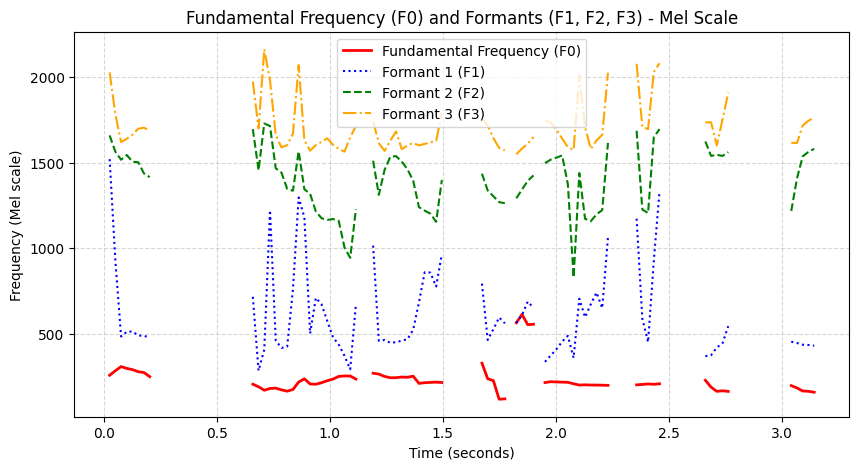

In [18]:
from IPython.display import Audio

# Sample one row
sample = df.sample()
gender = sample["gender"].values[0]
print("Gender:", gender)
file_name = sample["path"].values[0]
y, sr = load_and_normalize_audio(file_name=file_name)

snd = parselmouth.Sound(y, sampling_frequency=sr)

# Extract F0
time_step = 0.025
pitch = snd.to_pitch(time_step=time_step)
pitch_times = np.linspace(pitch.start_time, pitch.end_time, pitch.n_frames)
f0_values = pitch.selected_array['frequency']
f0_values[f0_values == 0] = np.nan  # Remove unvoiced (0) values

# Extract formants
formants = snd.to_formant_burg(time_step=time_step, max_number_of_formants=5, maximum_formant=5500)
f1_values = np.array([formants.get_value_at_time(1, t) for t in pitch_times])
f2_values = np.array([formants.get_value_at_time(2, t) for t in pitch_times])
f3_values = np.array([formants.get_value_at_time(3, t) for t in pitch_times])

# **Apply NaN mask to formants wherever F0 is NaN**
f1_values[np.isnan(f0_values)] = np.nan
f2_values[np.isnan(f0_values)] = np.nan
f3_values[np.isnan(f0_values)] = np.nan

# Convert frequencies to Mel scale
f0_mel = hz_to_mel(f0_values)
f1_mel = hz_to_mel(f1_values)
f2_mel = hz_to_mel(f2_values)
f3_mel = hz_to_mel(f3_values)

# Plot F0 and formants on the Mel scale
plt.figure(figsize=(10, 5))
plt.plot(pitch_times, f0_mel, label="Fundamental Frequency (F0)", color="red", linewidth=2)
plt.plot(pitch_times, f1_mel, label="Formant 1 (F1)", color="blue", linestyle="dotted")
plt.plot(pitch_times, f2_mel, label="Formant 2 (F2)", color="green", linestyle="dashed")
plt.plot(pitch_times, f3_mel, label="Formant 3 (F3)", color="orange", linestyle="dashdot")

# Labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Mel scale)")
plt.title("Fundamental Frequency (F0) and Formants (F1, F2, F3) - Mel Scale")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Play audio
Audio(data=y, rate=sr)

In [19]:
X = []  # List to store feature vectors
y_labels = []  # List to store labels (e.g., speaker ID, emotion, etc.)

count = 0

for index, row in df.iterrows():
    count += 1
    print("Sample:", count)
    
    y, sr = load_and_normalize_audio(file_name=row["path"])
    snd = parselmouth.Sound(y, sampling_frequency=sr)

    # Extract F0
    time_step = 0.025
    pitch = snd.to_pitch(time_step=time_step)
    pitch_times = np.linspace(pitch.start_time, pitch.end_time, pitch.n_frames)
    f0_values = pitch.selected_array['frequency']
    f0_values[f0_values == 0] = np.nan  # Remove unvoiced (0) values

    # Extract formants
    formants = snd.to_formant_burg(time_step=time_step, max_number_of_formants=5, maximum_formant=5500)
    f1_values = np.array([formants.get_value_at_time(1, t) for t in pitch_times])
    f2_values = np.array([formants.get_value_at_time(2, t) for t in pitch_times])
    f3_values = np.array([formants.get_value_at_time(3, t) for t in pitch_times])

    # **Apply NaN mask to formants wherever F0 is NaN**
    f1_values[np.isnan(f0_values)] = np.nan
    f2_values[np.isnan(f0_values)] = np.nan
    f3_values[np.isnan(f0_values)] = np.nan

    # Convert frequencies to Mel scale
    f0_mel = hz_to_mel(f0_values)
    f1_mel = hz_to_mel(f1_values)
    f2_mel = hz_to_mel(f2_values)
    f3_mel = hz_to_mel(f3_values)
    
    # Stack features into a single array (shape: [n_timesteps, 4])
    feature_vector = np.column_stack((f0_mel, f1_mel, f2_mel, f3_mel))

    # Store in X
    X.append(feature_vector)
    y_labels.append(row["gender"])  # Example label (can be speaker ID, phoneme, etc.)
    
# Convert to NumPy array for ML training
X = np.array(X, dtype=object)  # Variable-length sequences need dtype=object
y_labels = np.array(y_labels)

print("Shape of X:", len(X), "sequences of varying length")
print("First sequence shape:", X[0].shape)  # (n_timesteps, 4)
print("Second sequence shape:", X[1].shape)  # (n_timesteps, 4)

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30
Sample: 31
Sample: 32
Sample: 33
Sample: 34
Sample: 35
Sample: 36
Sample: 37
Sample: 38
Sample: 39
Sample: 40
Sample: 41
Sample: 42
Sample: 43
Sample: 44
Sample: 45
Sample: 46
Sample: 47
Sample: 48
Sample: 49
Sample: 50
Sample: 51
Sample: 52
Sample: 53
Sample: 54
Sample: 55
Sample: 56
Sample: 57
Sample: 58
Sample: 59
Sample: 60
Sample: 61
Sample: 62
Sample: 63
Sample: 64
Sample: 65
Sample: 66
Sample: 67
Sample: 68
Sample: 69
Sample: 70
Sample: 71
Sample: 72
Sample: 73
Sample: 74
Sample: 75
Sample: 76
Sample: 77
Sample: 78
Sample: 79
Sample: 80
Sample: 81
Sample: 82
Sample: 83
Sample: 84
Sample: 85
Sample: 86
Sample: 87
Sample: 88
Sample: 89
Sample: 90
Sample: 91
Sample: 

In [20]:
from tensorflow.keras.layers import Masking, LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert to padded NumPy array & Replace NaNs
X_padded = pad_sequences(X, dtype="float32", padding="post", value=np.nan)
X_padded = np.nan_to_num(X_padded, nan=0.0)  # Replace NaNs with 0

print("Padded X shape:", X_padded.shape)  # (n_samples, max_timesteps, num_features)

# Convert categorical labels to integer labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_labels)  # Maps strings to numbers
y_labels = np.array(y_labels, dtype="int32")  # Ensure integer labels for classification

# Define Model
inputs = Input(shape=(None, 4))  # Variable-length input
x = Masking(mask_value=0.0)(inputs)  # Ignore NaN-replaced values
x = LSTM(32)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

rnn = Model(inputs, output)
rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
rnn.fit(X_padded, y_labels, epochs=20, batch_size=32)

Padded X shape: (5322, 601, 4)
Epoch 1/20


2025-01-31 01:16:07.617638: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51176352 exceeds 10% of free system memory.


167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 335ms/step - accuracy: 0.5814 - loss: 0.6864
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 347ms/step - accuracy: 0.7426 - loss: 0.5607
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 330ms/step - accuracy: 0.7648 - loss: 0.5286
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 54s 326ms/step - accuracy: 0.7788 - loss: 0.5021
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 332ms/step - accuracy: 0.8340 - loss: 0.4228
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 327ms/step - accuracy: 0.8380 - loss: 0.4131
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.8376 - loss: 0.3987
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 330ms/step - accuracy: 0.8475 - loss: 0.3787
Epoch 9/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 328ms/step - accuracy: 0.8573 - loss: 0.3689
Epoch 10/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.8570 - loss: 0.3670
Epoch 11/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 346ms/step - accuracy: 0.8539 - loss: 0.3610
Epoch 12/20
167/167 ━━━━━━━━━━

In [23]:
rnn.save(filepath="rnn.keras")

## CNN